In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:6


In [2]:
from bliss import sleep
from bliss.datasets import simulated

In [3]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [6]:
with initialize(config_path="../../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [11]:
cfg.model.decoder.kwargs.update({'n_bands': 2, 
                                 'slen': 300, 
                                 'tile_slen': 10, 
                                 'ptile_slen': 30, 
                                 'border_padding': 5, 
                                 'background_values': [667., 495], 
                                 'psf_params_file': './psf/ziband_psf_fitted.npy'})

cfg.model.encoder.kwargs.update({'ptile_slen': 20})

cfg.dataset.kwargs.update({'n_batches': 1, 'batch_size': 1})


In [12]:
model_filename = './fits/starnet_decaps_zi'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [13]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [66]:
border_padding = sleep_net.image_encoder.border_padding

# load data

In [25]:
# from astropy.io import fits
# hdul = fits.open('../../../../decaps/data/decaps_l0_b0_hdu08_z')

# image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

# slen = 300
# x0 = 20
# x1 = 20

In [26]:
# dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)
# out = dataset.get_batch()
# image = out['images']

# slen = 300
# x0 = border_padding
# x1 = border_padding

In [35]:
image = torch.Tensor(np.load('./aligned_image_zi.npy'))

slen = 300
x0 = 20
x1 = 20

In [36]:
test_image = plotting.crop_image(image, 
                                 x0 - border_padding, 
                                 x1 - border_padding,
                                 slen + 2 * border_padding,
                                 slen + 2 * border_padding)

In [64]:
sleep_net.image_encoder.border_padding

5

In [37]:
test_image.shape

torch.Size([1, 2, 310, 310])

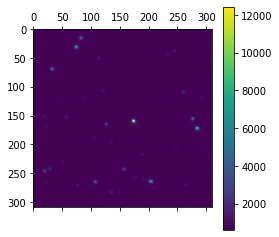

In [38]:
plt.matshow(test_image.cpu().numpy()[0, 0])
plt.colorbar()

# Get starnet map estimates

In [39]:
map_estimate = sleep_net.image_encoder.map_estimate(test_image.to(device), slen)

# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

(array([[0., 0., 8., 5., 6., 9., 2., 4., 4., 4.],
        [7., 1., 7., 2., 8., 4., 3., 4., 2., 4.]]),
 array([2.4865212, 2.7685354, 3.0505497, 3.3325639, 3.6145782, 3.8965924,
        4.1786065, 4.460621 , 4.7426353, 5.024649 , 5.3066635],
       dtype=float32),
 <a list of 2 BarContainer objects>)

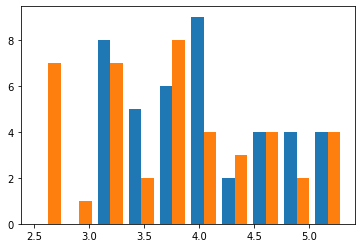

In [40]:
plt.hist(np.log10(map_estimate['fluxes'].squeeze().numpy()))

In [41]:
map_estimate['fluxes'].min()

tensor(306.5640)

### Check the coverage

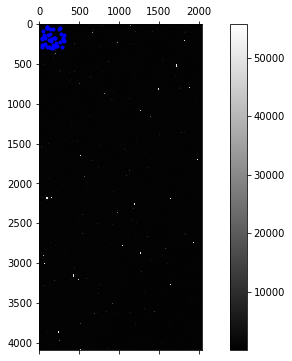

In [42]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='.',
        color='b', 
    )

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

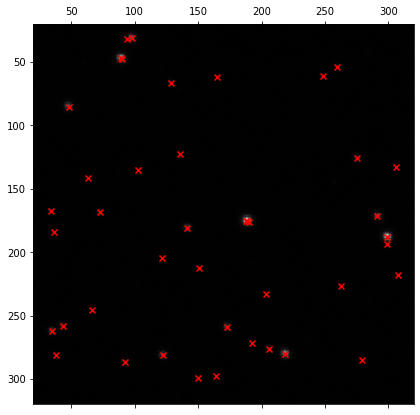

In [43]:
f, axarr = plt.subplots(1, 1, figsize=(8, 7))

plotting.plot_locations(
    map_estimate['locs'], 
    axarr,
    marker='x',
    color='r',
)


im = plotting.plot_image(axarr, 
                         image[0, 0], 
                         x1, 
                         x0,
                         slen,
                         slen)

f.colorbar(im, ax = ax)

In [44]:
# f, axarr = plt.subplots(1, 1, figsize=(4, 3))

# plotting.plot_locations(
#     map_estimate['locs'], 
#     axarr,
#     marker='x',
#     color='r',
# )

# # _x0 = 123
# # _x1 = 295
# _x0 = 236
# _x1 = 57

# subimage_slen = 20


# im = plotting.plot_image(axarr, 
#                          image[0, 0], 
#                          _x0, 
#                          _x1,
#                          subimage_slen,
#                          subimage_slen)

# f.colorbar(im, ax = axarr)

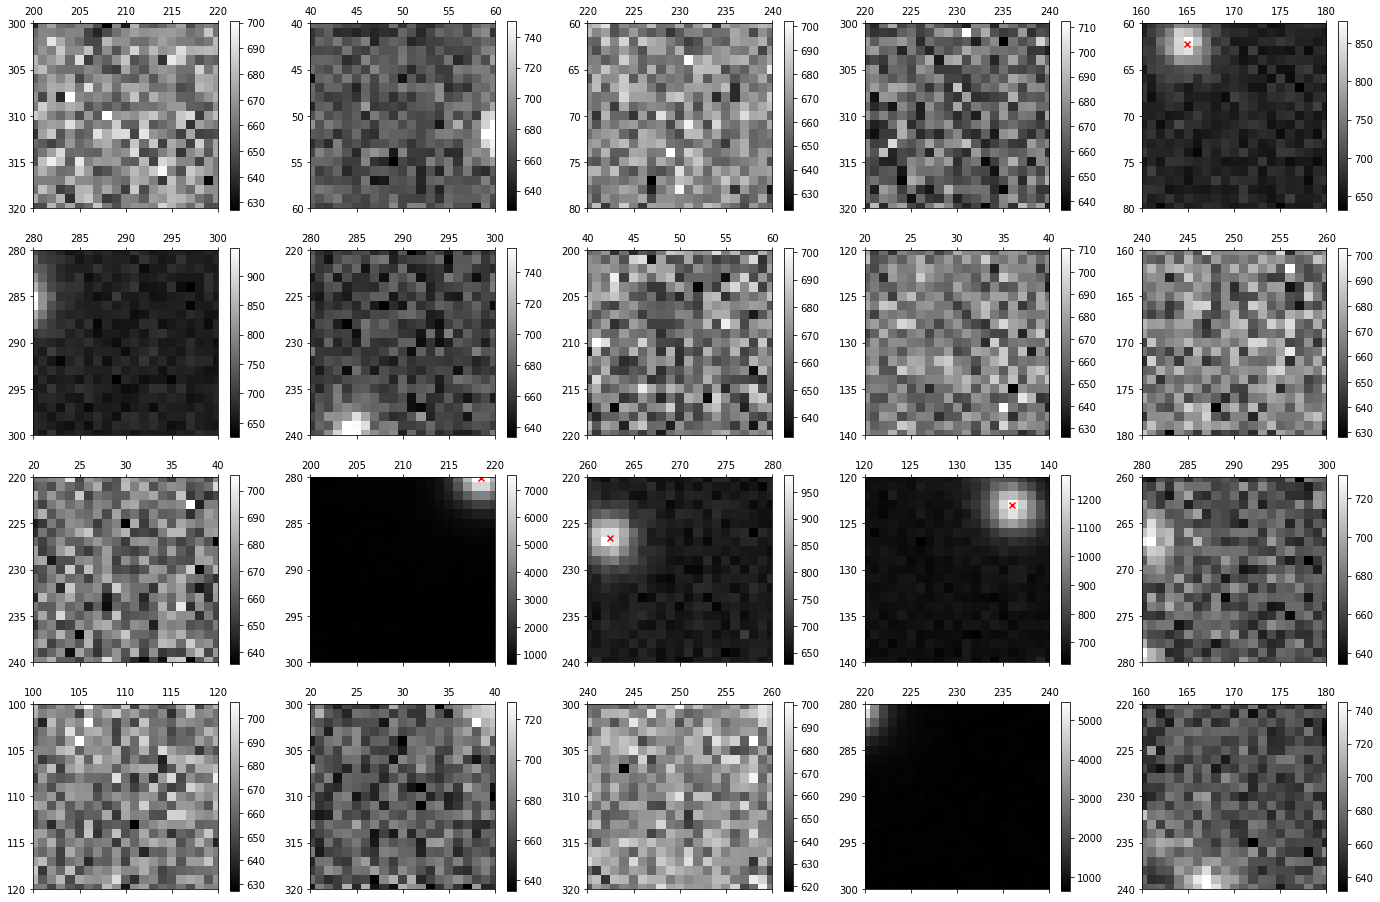

In [45]:
f, axarr = plt.subplots(4, 5, figsize=(24, 16))

# np.random.seed(3)

subimage_slen = 20
x0_vec = np.arange(x0, x0 + slen, subimage_slen)
x1_vec = np.arange(x1, x1 + slen, subimage_slen)

for i in range(20): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
        
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

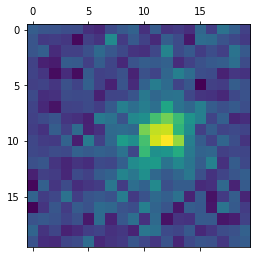

In [46]:
# x0 = 32
# x1 = 275

_x0 = 200
_x1 = 180

subimage_slen = 20


foo = image[:, :, _x0:(_x0 + subimage_slen), _x1:(_x1 + subimage_slen)]
plt.matshow(foo[0, 0])

In [47]:
sleep_net.image_encoder.tile_map_n_sources(foo.to(device))

tensor([0], device='cuda:6')

# Color magnitude diagrams

In [61]:
# give some border -- after borders may be zero-padded
border = 20
image_cmd = plotting.crop_image(image, 
                                border, 
                                border,
                                image.shape[-2] - 2 * border,
                                image.shape[-1] - 2 * border)

In [79]:
test_im_slen = 100

In [82]:
x0_vec = np.arange(border_padding, 
                   image_cmd.shape[-2] - test_im_slen - border_padding, 
                   test_im_slen)

x1_vec = np.arange(border_padding, 
                   image_cmd.shape[-1] - test_im_slen - border_padding, 
                   test_im_slen)

In [103]:
i = 0
for i in range(len(x0_vec)): 
    for j in range(len(x1_vec)): 
        _x0 = x0_vec[i]
        _x1 = x1_vec[j]
        
        # print('x0: ' + str(_x0) + '; ' + 'x1: ', str(_x1))
        
        test_image = \
            plotting.crop_image(image_cmd, 
                                _x0 - border_padding, 
                                _x1 - border_padding,
                                test_im_slen + 2 * border_padding,
                                test_im_slen + 2 * border_padding)
        
        map_estimate = sleep_net.image_encoder.map_estimate(test_image.to(device),
                                                            test_im_slen)
        
        log_fluxes_i = torch.log10(map_estimate['fluxes'])
        log_fluxes_i = log_fluxes_i.squeeze(0).detach().cpu().numpy()
        
        if((i == 0) & (j == 0)): 
            log_fluxes = log_fluxes_i
        else: 
            log_fluxes = np.vstack([log_fluxes, log_fluxes_i])

print('done.')

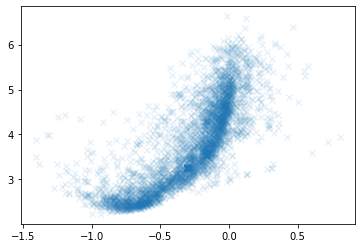

In [116]:
plt.scatter(log_fluxes[:, 1] - log_fluxes[:, 0], 
            log_fluxes[:, 1], 
            alpha = 0.1, 
            marker = 'x')